In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [2]:
from torchvision.io import read_image
from torchvision.transforms import Resize

import torch as tn
import torch.nn as nn
import torchtt as tntt

from torch import optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import numpy as np

from tqdm.notebook import tqdm
from utils.triplets import ImageTriplets

from time import time

device = tn.device('cuda' if tn.cuda.is_available() else 'cpu')

/home/usr/myenv/lib/python3.12/site-packages/torchtt/_dmrg.py:19: UserWarning: 
C++ implementation not available. Using pure Python.

  warnings.warn("\x1B\nC++ implementation not available. Using pure Python.\n\033")
/home/usr/myenv/lib/python3.12/site-packages/torchtt/_amen.py:21: UserWarning: 
C++ implementation not available. Using pure Python.

  warnings.warn(
/home/usr/myenv/lib/python3.12/site-packages/torchtt/solvers.py:21: UserWarning: 
C++ implementation not available. Using pure Python.

  warnings.warn(
/home/usr/myenv/lib/python3.12/site-packages/torchtt/cpp.py:12: UserWarning: 
C++ implementation not available. Using pure Python.

  warnings.warn("\x1B\nC++ implementation not available. Using pure Python.\n\033")
/home/usr/myenv/lib/python3.12/site-packages/torchtt/__init__.py:34: UserWarning: 
C++ implementation not available. Using pure Python.

  warnings.warn(


In [3]:
DETECTION_CLASSES = 6

class BasicTT(nn.Module):
    def __init__(self):
        super().__init__()
        self.ttl1 = tntt.nn.LinearLayerTT([1, 500, 500, 500], 
                                          [8, 100, 100, 100],
                                          [1, 2  , 2  , 2   , 1])
        
        self.ttl2 = tntt.nn.LinearLayerTT([8, 100, 100, 100],
                                          [8, 50 , 50 , 50 ], 
                                          [1, 5  , 5  , 5   , 1])

        self.ttl3 = tntt.nn.LinearLayerTT([8, 50, 50, 50],
                                          [2, 8, 8, 8],
                                          [1,10,10, 10, 1])
        
        self.linear1 = nn.Linear(1024, 512, dtype = tn.float32)

        self.linear2 = nn.Linear(512, DETECTION_CLASSES, dtype = tn.float32)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.ttl1(x)
        x = tn.relu(x)
        x = self.ttl2(x)
        x = tn.relu(x)
        x = self.ttl3(x)
        x = tn.relu(x)
        
        x = x.view(-1,1024)
        x = self.linear1(x)
        x = tn.relu(x)
        x = self.linear2(x)
        return self.softmax(x)

In [4]:
# ОЗУ требует в 7.8 раз больше времени на шаг оптимизации

# ИЗВЛЕКАЕМ ПРИЗННАКИ ИЗОБРАЖЕНИЙ

In [5]:
from torchvision.models import resnet50, ResNet50_Weights
from torchsummary import summary

class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        

        self.conv = resnet50(weights=ResNet50_Weights.DEFAULT)
        for param in self.conv.parameters():
            param.requires_grad = False

        self.fc1 = nn.Sequential(
            nn.Linear(in_features = 1000, out_features = 500, bias=True),
            nn.BatchNorm1d(500, momentum = 0.5),
            nn.LeakyReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features = 500, out_features = 500, bias=True),
            nn.BatchNorm1d(500, momentum = 0.5),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features = 500, out_features = 500, bias=True),
            nn.BatchNorm1d(500, momentum = 0.5),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features = 500, out_features = DETECTION_CLASSES, bias=True),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 1000)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def encode(self, x):
        x = self.conv(x)
        x = x.view(-1, 1000)
        x = self.fc1(x)
        return x

In [4]:
dataset = ImageTriplets("/home/usr/Documents/Datasets/co3d", triplets=False)
train_datset, val_dataset = tn.utils.data.random_split(dataset, [len(dataset)-8000, 8000])

train_loader = DataLoader(
        train_datset,
        batch_size=64,
        num_workers=8,
        pin_memory=True,
        shuffle=True,
        drop_last = True
)

val_loader = DataLoader(
        val_dataset,
        batch_size=64,
        num_workers=2,
        pin_memory=True,
        shuffle=False,
        drop_last = True
)

In [5]:
model = ResNet50().to(device)
optimizer = tn.optim.Adam(model.parameters(), lr = 0.001)
criterion = tn.nn.BCELoss()

train_losses = []
val_losses = []

In [6]:
epo = 3

for _ in tqdm(range(epo)):
    epo_train_losses = []
    epo_val_losses = []
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data.to(device))
        loss = criterion(output, target.to(device))
        loss.backward()
        optimizer.step()
        epo_train_losses.append(loss.item())
        
    train_losses.append(sum(epo_train_losses)/len(epo_train_losses))
    model.eval()
    for data, target in val_loader:
        with tn.no_grad():
            output = model(data.to(device))
            loss = criterion(output, target.to(device))
            epo_val_losses.append(loss.item())
            
    val_losses.append(sum(epo_val_losses)/len(epo_val_losses))

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
tn.save(model.state_dict(), "resnet50.pth")

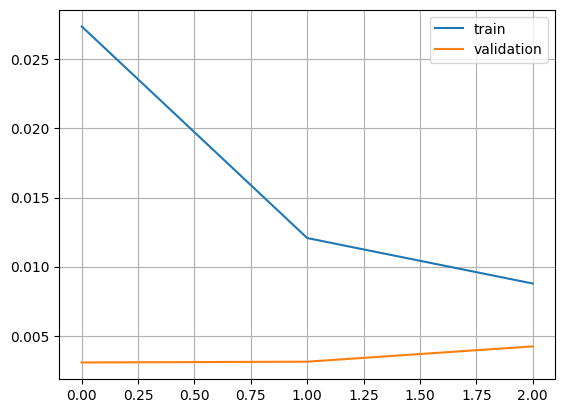

In [8]:
import matplotlib.pyplot as plt


plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')

plt.grid()
plt.legend()

In [9]:
def calculate_accuracy(model, dataloader, device=None):
    """
    Вычисляет accuracy модели на данных из DataLoader.
    
    Аргументы:
        model: модель PyTorch (в режиме eval).
        dataloader: DataLoader, возвращающий пары (input, target),
                    где target — one-hot вектор (тензор размера [batch_size, num_classes]).
        device: устройство ('cpu' или 'cuda'), на которое переносить данные (опционально).
    
    Возвращает:
        accuracy (float): доля правильных предсказаний.
    """
    model.eval()  # Переводим модель в режим оценки
    correct = 0
    total = 0

    with tn.no_grad():  # Отключаем вычисление градиентов
        for inputs, targets in dataloader:
            # Переносим данные на указанное устройство
            if device:
                inputs = inputs.to(device)
                targets = targets.to(device)

            # Получаем предсказания модели
            outputs = model(inputs)  # [batch_size, num_classes]

            # Преобразуем one-hot targets в индексы классов
            # Например, [0, 1, 0, 0] -> 1
            target_classes = tn.argmax(targets, dim=1)  # [batch_size]

            # Получаем предсказанные классы (индексы с максимальным значением)
            predicted_classes = tn.argmax(outputs, dim=1)  # [batch_size]

            # Считаем количество правильных предсказаний
            correct += (predicted_classes == target_classes).sum().item()
            total += targets.size(0)  # Размер батча

    accuracy = correct / total if total > 0 else 0.0
    return accuracy

calculate_accuracy(model, val_loader, device=device)

0.997125

## Подключаем ТТ модель

In [6]:
dataset = ImageTriplets("/home/usr/Documents/Datasets/co3d", triplets=True)
train_datset, val_dataset = tn.utils.data.random_split(dataset, [len(dataset)-6000, 6000])

train_loader = DataLoader(
        train_datset,
        batch_size=1,
        num_workers=8,
        pin_memory=True,
        shuffle=True,
        drop_last = True
)

val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        num_workers=2,
        pin_memory=True,
        shuffle=False,
        drop_last = True
)

In [7]:
model_TT = BasicTT().to(device)

model = ResNet50().to(device)
model.load_state_dict(tn.load("resnet50.pth", weights_only=True))

criterion = tn.nn.BCELoss()
optimizer = optim.Adam(model_TT.parameters(), lr = 0.0003)

train_losses = []
val_losses = []

In [8]:
epo = 1

for _ in tqdm(range(epo)):
    epo_train_losses = []
    epo_val_losses = []
    model.eval()
    model_TT.train()
    for data, target in train_loader:
        with tn.no_grad():
            embed1 = model.encode(data[0].to(device))[0]
            embed2 = model.encode(data[1].to(device))[0]
            embed3 = model.encode(data[2].to(device))[0]

            embed = embed1.unsqueeze(1).unsqueeze(2) * embed2.unsqueeze(0).unsqueeze(2) * embed3.unsqueeze(0).unsqueeze(0)

        optimizer.zero_grad()
        output = model_TT(embed.unsqueeze(0))
        
        loss = criterion(output, target.to(device))
        loss.backward()
        optimizer.step()
        epo_train_losses.append(loss.item())
        
    train_losses.append(sum(epo_train_losses)/len(epo_train_losses))
    
    model_TT.eval()
    for data, target in val_loader:
        with tn.no_grad():
            embed1 = model.encode(data[0].to(device))[0]
            embed2 = model.encode(data[1].to(device))[0]
            embed3 = model.encode(data[2].to(device))[0]

            embed = embed1.unsqueeze(1).unsqueeze(2) * embed2.unsqueeze(0).unsqueeze(2) * embed3.unsqueeze(0).unsqueeze(0)
            
            output = model_TT(embed.unsqueeze(0))
            loss = criterion(output, target.to(device))

            epo_val_losses.append(loss.item())

    val_losses.append(sum(epo_val_losses)/len(epo_val_losses))

  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
tn.save(model_TT.state_dict(), "resnet+TT2.pth")

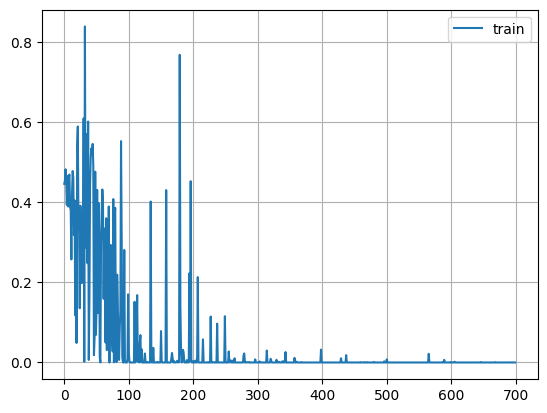

In [20]:
import matplotlib.pyplot as plt


plt.plot(epo_train_losses[:700], label='train')
# plt.plot(epo_val_losses[:700], label='validation')

plt.grid()
plt.legend()

In [10]:
train_losses

[25.955801151815184]

In [11]:
val_losses

[26.3722242342631]

In [12]:
def calculate_accuracy_trilets(model, model_TT, dataloader, device=None):
    model.eval()  # Переводим модель в режим оценки
    correct = 0
    total = 0

    with tn.no_grad():  # Отключаем вычисление градиентов
        for data, targets in dataloader:
            embed1 = model.encode(data[0].to(device))[0]
            embed2 = model.encode(data[1].to(device))[0]
            embed3 = model.encode(data[2].to(device))[0]

            embed = embed1.unsqueeze(1).unsqueeze(2) * embed2.unsqueeze(0).unsqueeze(2) * embed3.unsqueeze(0).unsqueeze(0)
            
            outputs = model_TT(embed.unsqueeze(0))

            # Преобразуем one-hot targets в индексы классов
            # Например, [0, 1, 0, 0] -> 1
            target_classes = tn.argmax(targets.to(device), dim=1)  # [batch_size]

            # Получаем предсказанные классы (индексы с максимальным значением)
            predicted_classes = tn.argmax(outputs, dim=1)  # [batch_size]

            # Считаем количество правильных предсказаний
            correct += (predicted_classes == target_classes).sum().item()
            total += targets.size(0)  # Размер батча

    accuracy = correct / total if total > 0 else 0.0
    return accuracy


In [13]:
calculate_accuracy_trilets(model, model_TT, val_loader, device=device)

0.20883333333333334